In [1]:
import sklearn.externals as extjoblib
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import KFold, cross_val_score

from dask.distributed import Client
import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split
import mlxtend
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import mlxtend
from sklearn.neighbors import KNeighborsRegressor
from random import sample

import statsmodels.api as sm
from multiprocessing import Process
import os
import time
from concurrent.futures import as_completed

In [2]:
independent = 'Poverty'
outer_k = 10
inner_k = 10
random_st = sample(list(np.arange(0,10,1)),1)[0]
print(random_st)

# configure the cross-validation procedure
cv_inner = KFold(n_splits=inner_k, shuffle=True, random_state=random_st)
cv_outer = KFold(n_splits=outer_k, shuffle=True, random_state=random_st+1)

3


In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/thistleknot/python-ml/master/data/raw/states.csv')
independent = 'Poverty'

y = data[[independent]]
X = data.loc[:, ~data.columns.isin([independent,'States'])].copy()

# configure the cross-validation procedure
outer_k = 10
inner_k = 10
random_st = sample(list(np.arange(0,10,1)),1)[0]
#print(random_st)

cv_inner = KFold(n_splits=inner_k, shuffle=True, random_state=random_st)
cv_outer = KFold(n_splits=outer_k, shuffle=True, random_state=random_st+1)


In [4]:

inner_folds = []
outer_folds = []

for outer_train_ix, outer_test_ix in cv_outer.split(X.index):

    inner_results = []

    for inner_train_ix, inner_test_ix in cv_inner.split(outer_train_ix):
        inner_folds.append([inner_train_ix,inner_test_ix])
    
    outer_folds.append([outer_train_ix, outer_test_ix])
        

In [5]:
#[*cv_outer.split(X.index)]

X_inner_train_sets = [X.loc[f[0]][0:10] for f in inner_folds]
y_inner_train_sets = [y.loc[f[0]][0:10] for f in inner_folds]

X_inner_test_sets = [X.loc[f[1][0:10]] for f in inner_folds]
y_inner_test_sets = [y.loc[f[1][0:10]] for f in inner_folds]

X_outer_train_sets = [X.loc[f[0]][0:10] for f in outer_folds]
y_outer_train_sets = [y.loc[f[0]][0:10] for f in outer_folds]

X_outer_test_sets = [X.loc[f[1][0:10]] for f in outer_folds]
y_outer_test_sets = [y.loc[f[1][0:10]] for f in outer_folds]

In [6]:
npa = []
for i in range(0,len(outer_folds)):
    npa.append([pd.concat([X_inner_train_sets[i],X_inner_test_sets[i]],axis=0),pd.concat([y_inner_train_sets[i],y_inner_test_sets[i]],axis=0)])
    

In [7]:
def runSFS(npa_):
    [x_,y_] = npa_

    lm = LinearRegression()

    sfs1 = SFS(estimator=lm, 
               k_features=(1, len(X.columns)),
               forward=True, 
               floating=False, 
               n_jobs=1,
               scoring='neg_mean_squared_error',
               cv=cv_inner)         

    sfs1.fit(x_, y_)

    best_features = pd.DataFrame(sfs1.get_metric_dict()).T['feature_names'].iloc[np.argmin(abs(pd.DataFrame(sfs1.get_metric_dict()).T['avg_score']))]
    best_score = pd.DataFrame(sfs1.get_metric_dict()).T['avg_score'].iloc[np.argmin(abs(pd.DataFrame(sfs1.get_metric_dict()).T['avg_score']))]
    return([best_features,best_score])

In [8]:
def clientFunction(function_name,vars):
    client = Client('192.168.3.100:8786')
    future_ = client.map(function_name,npa)
    #results = []
    results = client.gather(future_)
    client.close()
    return results


In [9]:
inner_results = clientFunction(runSFS,npa)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\distributed\client.py:1265: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| dask        | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| distributed | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| lz4         | 3.1.3         | 3.1.10        | 3.1.10        |
| python      | 3.9.7.final.0 | 3.9.9.final.0 | 3.9.9.final.0 |
| toolz       | 0.11.1        | 0.11.2        | 0.11.2        |
+-------------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


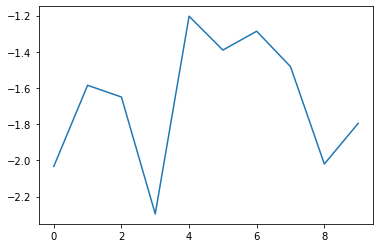

In [10]:
plt.plot([i[1] for i in inner_results])

In [11]:
inner_results

[[('White', 'Unemployed', 'Income'), -2.033123317930626],
 [('Traf Deaths', 'Income', 'Population'), -1.5849391792479408],
 [('Infant Mort', 'Income'), -1.649869424128866],
 [('Crime', 'Income'), -2.295948716769422],
 [('Crime', 'Traf Deaths', 'Income', 'Population'), -1.2034156728087142],
 [('Income', 'Population'), -1.390302218801288],
 [('Crime', 'Unemployed', 'Income'), -1.286216703019544],
 [('Income',), -1.4820284690797336],
 [('Income',), -2.0201509175091044],
 [('White', 'Crime', 'Unemployed', 'Income'), -1.7955146939435227]]

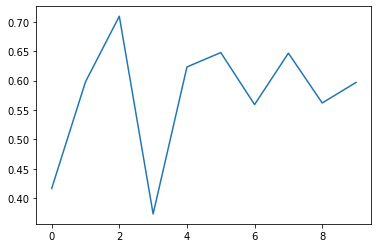

In [21]:
plt.plot([o for o in outer_results])

In [12]:
best_subset = pd.DataFrame(inner_results).iloc[:,0][np.argmin(abs(pd.DataFrame(inner_results).iloc[:,1]))]

In [13]:
best_subset

('Crime', 'Traf Deaths', 'Income', 'Population')

In [14]:
npa = []
for i in range(0,len(outer_folds)):
    npa.append([pd.concat([X_outer_train_sets[i],X_outer_test_sets[i]],axis=0),pd.concat([y_outer_train_sets[i],y_outer_test_sets[i]],axis=0),best_subset])

In [15]:
def runSFS2(npa_):
    [x_,y_,f_] = npa_

    outer_model = LinearRegression()

    outer_model.fit(x_, y_)

    y_pred = outer_model.predict(x_)
    
    return(np.mean(abs(y_pred.ravel()-y_.values.ravel())))

In [16]:
outer_results = clientFunction(runSFS2,npa)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\distributed\client.py:1265: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| dask        | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| distributed | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| lz4         | 3.1.3         | 3.1.10        | 3.1.10        |
| python      | 3.9.7.final.0 | 3.9.9.final.0 | 3.9.9.final.0 |
| toolz       | 0.11.1        | 0.11.2        | 0.11.2        |
+-------------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))



outer cv abs error mean:  0.5733069027136988
outer cv abs error std:  0.09907855783109261
Final Model


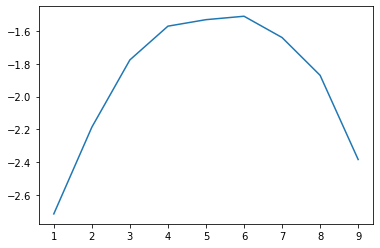

6 ('White', 'Traf Deaths', 'University', 'Unemployed', 'Income', 'Population')
best_score -1.5082044160896386
SFS CV Score: -1.5082044160896386
                            OLS Regression Results                            
Dep. Variable:                Poverty   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     49.63
Date:                Sat, 23 Jul 2022   Prob (F-statistic):           9.59e-18
Time:                        23:56:16   Log-Likelihood:                -72.594
No. Observations:                  50   AIC:                             159.2
Df Residuals:                      43   BIC:                             172.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.02

Text(0.5, 1.0, 'Comparison of mean accuracy obtained on the test sets with\nand without nested cross-validation')

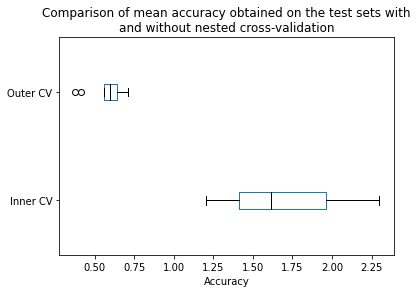

In [22]:
client = Client('192.168.3.100:8786')
lm = LinearRegression()
#model that performed best on the outer (out of sample) forecasts is selected        2
print()
print("outer cv abs error mean: ",np.mean(outer_results))
print("outer cv abs error std: ",np.std(outer_results))

print("Final Model")
final_model = LinearRegression()

sfs2 = SFS(estimator=lm, 
           k_features=(1, len(X.columns)),
           forward=True, 
           floating=False, 
           n_jobs=-1,
           scoring='neg_mean_squared_error',
           cv=cv_outer)   

with joblib.parallel_backend('dask'):
    sfs2.fit(X,y)
    
plt.plot(pd.DataFrame(sfs2.get_metric_dict()).T['avg_score'])
plt.show()
best_features = pd.DataFrame(sfs2.get_metric_dict()).T['feature_names'].iloc[np.argmin(abs(pd.DataFrame(sfs2.get_metric_dict()).T['avg_score']))]
print(len(best_features),best_features)
best_score = pd.DataFrame(sfs2.get_metric_dict()).T['avg_score'].iloc[np.argmin(abs(pd.DataFrame(sfs2.get_metric_dict()).T['avg_score']))]
print("best_score", best_score)

#print("SFS CV Score:", sfs2.k_score_)
#define response variable
#add constant to predictor variables
x = sm.add_constant(X[np.array(best_features)])

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

all_scores = {
    "Inner CV": [abs(r[1]) for r in inner_results],
    "Outer CV": outer_results,
}
all_scores = pd.DataFrame(all_scores)

color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores.plot.box(color=color, vert=False)
plt.xlabel("Accuracy")
plt.title("Comparison of mean accuracy obtained on the test sets with\n"
              "and without nested cross-validation")